In [10]:
import multiprocessing
import os
import time
import numpy as np
from scipy.spatial import cKDTree
import open3d as o3d
import util
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import random
from BendLength import BendLengthCalculator

In [11]:
point_cloud_location = "/home/chris/Code/PointClouds/data/ply/CircularVentilationGrateExtraCleanedFull.ply"
pcd = o3d.io.read_point_cloud(point_cloud_location)

In [12]:
# Preprocess the point cloud
pcd = util.preProcessCloud(pcd)
pcd_points = np.asarray(pcd.points)

# Detect planes, intersections, and anchor points
segment_models, segments, segments_indices, main_surface_idx = util.multiOrderRansac(pcd, pt_to_plane_dist=0.4)
angles_rad = util.findAnglesBetweenPlanes(segment_models, main_surface_idx)
intersection_lines = util.findIntersectionLines(segment_models, main_surface_idx)
anchor_points = util.findAnchorPoints(segment_models, segments, intersection_lines, main_surface_idx)

sample_dist = 0.3
aggregation_range = 15
eigen_threshold = 0.05
angle_threshold = 0.12
radius = 1.5
bend_length_calculator = BendLengthCalculator(pcd, anchor_points, intersection_lines, eigen_threshold, angle_threshold, aggregation_range, sample_dist, radius)
bend_edges = bend_length_calculator.compute_bend_lengths()

# Calculate per point normal variance and 'core' points
all_normals, pointwise_variance = util.calculatePointwiseNormalVariance(pcd, radius=1.5)
core_indices = util.getCorePoints(pointwise_variance)

clusters = util.growRegionsAroundIntersections(anchor_points, core_indices, pointwise_variance, pcd_points, bend_edges, variance_percentile=95)

In [13]:
#print("Number of points in each cluster: ", [len(cluster) for cluster in clusters])
print("Anchors: ", anchor_points)
#print("Core points: ", core_indices)
print("Bend edges: ", bend_edges)
print("Clusters types:", type(clusters))
print("Number of clusters: ", len(clusters))

Anchors:  {1: array([ 41.19450893, 326.50103244, 475.00187119]), 2: array([ 78.21175438, 254.66274528, 475.22954313]), 3: array([-39.04537096, 320.18666622, 475.14018898]), 4: array([-40.04310393, 179.98191963, 475.68831175]), 5: array([-74.83269349, 252.14983568, 475.456198  ]), 6: array([ 43.58219456, 181.24227952, 475.5649044 ])}
Bend edges:  {1: (array([ 61.21394217, 363.76337446, 474.82820533]), array([ 15.77976744, 279.19635711, 475.22234062])), 2: (array([127.10818653, 255.24909058, 475.15797303]), array([ 30.51523468, 254.09078881, 475.29935692])), 3: (array([-63.23344703, 360.95039312, 475.01550972]), array([-13.78567126, 277.61695141, 475.270392  ])), 4: (array([-59.5150289 , 143.78764288, 475.85703705]), array([-13.74889867, 228.85740284, 475.46047102])), 5: (array([-122.22442145,  251.26714799,  475.52679156]), array([-27.44096553, 253.03252337, 475.38560443])), 6: (array([ 64.87948956, 145.39115389, 475.67452374]), array([ 16.00296363, 227.66819761, 475.4229513 ]))}
Cluste

In [14]:
#plane_points = np.asarray(segments[1].points)
plane_indices = segments_indices[0]
# plane_normals = all_normals[plane_indices]
bend_indices = list(clusters[2])
bend_points = pcd_points[bend_indices]
bend_normals = all_normals[bend_indices]

plane_indices = list(set(plane_indices) - set(clusters[2]))

In [15]:
plane_points = pcd_points[plane_indices]
plane_normals = all_normals[plane_indices]

In [16]:
class CombinedHistogramVisualizer:
    def __init__(self, plane_points, plane_normals, bend_points, bend_normals, bin_size=5):
        # Combine points and normals
        self.points = np.vstack((plane_points, bend_points))
        self.normals = np.vstack((plane_normals, bend_normals))
        self.bin_size = bin_size
        self.n_plane = len(plane_points)
        self.n_total = len(self.points)

        # Compute angles
        self.azimuth, self.zenith = self.compute_azimuth_zenith(self.normals)
        self.az_bins = np.arange(-180, 180 + bin_size, bin_size)
        self.zen_bins = np.arange(0, 180 + bin_size, bin_size)
        self.az_bin_idx = 0
        self.zen_bin_idx = 0
        self.mode = 'azimuth'

        # Open3D setup
        self.pcd = o3d.geometry.PointCloud()
        self.pcd.points = o3d.utility.Vector3dVector(self.points)
        self.vis = o3d.visualization.VisualizerWithKeyCallback()
        self.vis.create_window("Plane + Bend Normal Visualizer")
        self.vis.add_geometry(self.pcd)

        self.vis.register_key_callback(262, self.next_azimuth)  # →
        self.vis.register_key_callback(263, self.prev_azimuth)  # ←
        self.vis.register_key_callback(264, self.prev_zenith)   # ↓
        self.vis.register_key_callback(265, self.next_zenith)   # ↑

        # Histogram setup
        self.fig, self.axs = plt.subplots(1, 2, figsize=(10, 4))
        self.az_bar_plane = self.axs[0].hist(self.azimuth[:self.n_plane], bins=self.az_bins, alpha=0.5, color='blue', label='Plane')[2]
        self.az_bar_bend = self.axs[0].hist(self.azimuth[self.n_plane:], bins=self.az_bins, alpha=0.5, color='orange', label='Bend')[2]
        self.zen_bar_plane = self.axs[1].hist(self.zenith[:self.n_plane], bins=self.zen_bins, alpha=0.5, color='blue', label='Plane')[2]
        self.zen_bar_bend = self.axs[1].hist(self.zenith[self.n_plane:], bins=self.zen_bins, alpha=0.5, color='orange', label='Bend')[2]
        self.axs[0].set_title("Azimuth")
        self.axs[1].set_title("Zenith")
        self.axs[0].legend()
        self.axs[1].legend()
        plt.tight_layout()
        plt.ion()
        plt.show()

        self.update_visualization()

    def compute_azimuth_zenith(self, normals):
        az = np.degrees(np.arctan2(normals[:, 1], normals[:, 0]))
        zen = np.degrees(np.arccos(np.clip(normals[:, 2], -1.0, 1.0)))
        return az, zen

    def highlight_bin(self, mode):
        if mode == 'azimuth':
            start = self.az_bins[self.az_bin_idx]
            end = start + self.bin_size
            mask = (self.azimuth >= start) & (self.azimuth < end)
        else:
            start = self.zen_bins[self.zen_bin_idx]
            end = start + self.bin_size
            mask = (self.zenith >= start) & (self.zenith < end)

        # Base colors
        plane_base = np.array([0.5, 0.7, 1.0])   # light blue
        bend_base = np.array([1.0, 0.7, 0.4])    # light orange
        highlight = np.array([0.0, 1.0, 0.0])    # green

        colors = np.zeros((self.n_total, 3))
        colors[:self.n_plane] = plane_base
        colors[self.n_plane:] = bend_base
        colors[mask] = highlight
        self.pcd.colors = o3d.utility.Vector3dVector(colors)

    def update_histogram_highlights(self):
        for i, bar in enumerate(self.az_bar_plane):
            bar.set_color('green' if i == self.az_bin_idx and self.mode == 'azimuth' else 'blue')
        for i, bar in enumerate(self.az_bar_bend):
            bar.set_color('green' if i == self.az_bin_idx and self.mode == 'azimuth' else 'orange')
        for i, bar in enumerate(self.zen_bar_plane):
            bar.set_color('green' if i == self.zen_bin_idx and self.mode == 'zenith' else 'blue')
        for i, bar in enumerate(self.zen_bar_bend):
            bar.set_color('green' if i == self.zen_bin_idx and self.mode == 'zenith' else 'orange')

        self.fig.canvas.draw()
        self.fig.canvas.flush_events()

    def update_visualization(self):
        self.highlight_bin(self.mode)
        self.update_histogram_highlights()
        self.vis.update_geometry(self.pcd)

    def next_azimuth(self, vis):
        self.mode = 'azimuth'
        self.az_bin_idx = (self.az_bin_idx + 1) % len(self.az_bins[:-1])
        self.update_visualization()

    def prev_azimuth(self, vis):
        self.mode = 'azimuth'
        self.az_bin_idx = (self.az_bin_idx - 1) % len(self.az_bins[:-1])
        self.update_visualization()

    def next_zenith(self, vis):
        self.mode = 'zenith'
        self.zen_bin_idx = (self.zen_bin_idx + 1) % len(self.zen_bins[:-1])
        self.update_visualization()

    def prev_zenith(self, vis):
        self.mode = 'zenith'
        self.zen_bin_idx = (self.zen_bin_idx - 1) % len(self.zen_bins[:-1])
        self.update_visualization()

    def run(self):
        self.vis.run()
        self.vis.destroy_window()


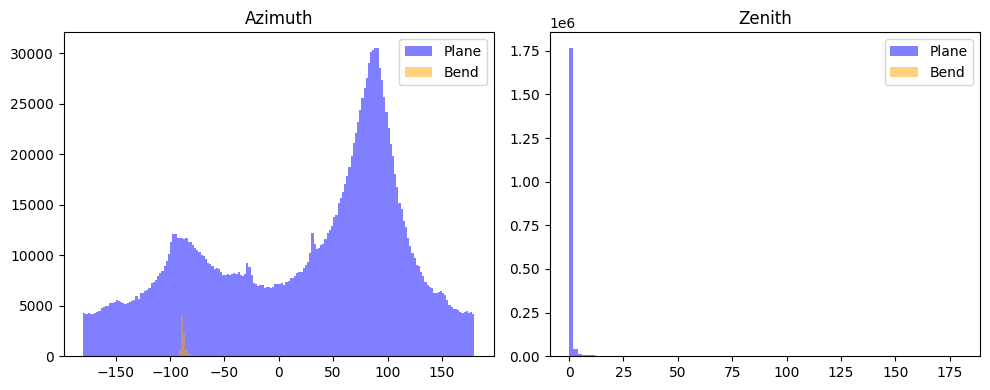

In [17]:
visualizer = CombinedHistogramVisualizer(plane_points, plane_normals, bend_points, bend_normals, bin_size=2)
visualizer.run()